In [119]:
from __future__ import division
import numpy as np
import pandas as pd
import yaml

import folium
import plotly.plotly as py
import plotly.graph_objs as go

%matplotlib inline
from IPython.core.display import display, HTML
import matplotlib.pyplot as plt
import seaborn as sns

import sys
print sys.version_info      # note use of python 2.7.12, not python 3.5

sys.version_info(major=2, minor=7, micro=12, releaselevel='final', serial=0)


### Load Data
- Provide some basic descriptive statistics on the collection of data

In [2]:
# load data
df_cta_info  = pd.read_csv("./../data/CTA_Info_LStops.csv") 
df_cta_rides = pd.read_csv("./../data/CTA_Ridership_LStation_DailyTotals.csv", parse_dates=['date'])

In [3]:
# some initial basic observations of the data
n_obs, n_features = df_cta_rides.shape
print "Num Observations: {0}, Num Features: {1}".format(n_obs, n_features)
n_daily_rides_recorded = len(df_cta_rides['date'].unique())
print "Num Daily Rides Recorded: {0}".format(n_daily_rides_recorded)
min_ts, max_ts = ( min(df_cta_rides['date']).strftime('%Y-%m-%d'), max(df_cta_rides['date']).strftime('%Y-%m-%d') )
print "Date Span: {0} - {1}".format(min_ts, max_ts)
n_stations = len(df_cta_rides['station_id'].unique())
n_station_names = len(df_cta_rides['stationname'].unique())
n_stations_mapped = len(df_cta_info['MAP_ID'].unique())
print "Num Stations: {0}, Num Station Names: {1}, Num Mapped Stations: {1}"\
.format(n_stations, n_station_names, n_stations_mapped)
n_totalrides = df_cta_rides['rides'].sum()
print "Num Total Rides: {0}".format(n_totalrides)
df_cta_rides.describe().T

Num Observations: 809326, Num Features: 5
Num Daily Rides Recorded: 5691
Date Span: 2001-01-01 - 2016-07-31
Num Stations: 146, Num Station Names: 147, Num Mapped Stations: 147
Num Total Rides: 2650747858


,count,mean,std,min,25%,50%,75%,max
station_id,809326.0,40759.453916,444.387019,40010.0,40370.0,40750.0,41150.0,41690.0
rides,809326.0,3275.253554,3144.853450,0.0,1112.0,2300.0,4329.0,36323.0


### Preprocessing
Perform some housekeeping via inspection and computation
- Some Station Names have the same Station ID (e.g. ['Skokie', 'Dempster-Skokie']) that need to be remapped
- The number of Daily Station Recordings gathered are not all the same, some have fewer than average
- There are a few Stations where there is no Station Line, Location, or Descriptive Information 
- There are some missing values for the CTA Information that need to be imputed

In [4]:
def col_missing_values(df_in):
    missing_vals = {col: df_in[df_in[col].isnull()].shape[0] for col in df_in.columns }
    cols_missing_vals = dict( filter(lambda (k,v): v != 0, missing_vals.items() ) )
    return cols_missing_vals

# This happens to be the all the same entries on the 'Green Line' only, fill this as False
df_cta_info_cl = df_cta_info.copy()
cols_missing_vals = col_missing_values(df_cta_info_cl)
print "CTA Info Missing Column Values:\n{}".format(cols_missing_vals)
df_cta_info_imp = df_cta_info_cl[df_cta_info_cl[cols_missing_vals.keys()[0]].isnull()]
print "Entries to be Imputed:";display(df_cta_info_imp)
df_cta_info_cl.iloc[df_cta_info_imp.index, :] = df_cta_info_cl.fillna(False)
#print "Entries Imputed:"; display(df_cta_info_cl.iloc[df_cta_info_imp.index,:])

CTA Info Missing Column Values:
{'BLUE': 2, 'Pexp': 2, 'P': 2, 'O': 2, 'BRN': 2, 'Pnk': 2, 'Y': 2, 'RED': 2}
Entries to be Imputed:


,STOP_ID,DIRECTION_ID,STOP_NAME,STATION_NAME,STATION_DESCRIPTIVE_NAME,MAP_ID,ADA,RED,BLUE,G,BRN,P,Pexp,Y,Pnk,O,Location
270,30381,N,Cermak-McCormick Place (Harlem-bound),Cermak-McCormick Place,Cermak-McCormick Place (Green Line),41690,True,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,"(41.853115, -87.626402)"
274,30382,S,Cermak-McCormick Place (63rd-bound),Cermak-McCormick Place,Cermak-McCormick Place (Green Line),41690,True,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,"(41.853115, -87.626402)"


In [5]:
# Drop a duplicate entry via name, but mapped to same MAP_ID
def clean_mismatched_stationnames(df_info_in):
    cols = ['MAP_ID', 'STATION_NAME']
    df_info = df_info_in[cols].drop_duplicates().reset_index().drop('index',axis=1)
    print 'Station Name Mismatch:\n{}'.format(df_info[df_info.MAP_ID.duplicated() == 1])
    # drop the STATION_NAME with 95th/Ran Ryan, keep 95th/Dan Ryan
    df_info = df_info_in[df_info_in['STATION_NAME'] != '95th/Ran Ryan']
    return df_info

# there is an entry (Roosevelt that has two locations due to Multiple Stop Ids, we can be less precise)
def lessprecise_latlong(df_info_in):
    cols = ['MAP_ID', 'Location']
    df_info = df_info_in[cols].drop_duplicates().reset_index().drop('index',axis=1)
    cond = df_info[df_info.MAP_ID.duplicated() == 1]['Location']
    if len(cond):
        print 'Less Precise Lat Long to Drop:\n{0}'.format(cond)
        df_info = df_info_in[~df_info_in.Location.isin(cond)]
    else:
        df_info = df_info_in
    return df_info

df_cta_info_cl = clean_mismatched_stationnames(df_cta_info_cl)
df_cta_info_cl = lessprecise_latlong(df_cta_info_cl)

Station Name Mismatch:
   MAP_ID   STATION_NAME
9   40450  95th/Ran Ryan
Less Precise Lat Long to Drop:
130    (41.867368, -87.627402)
Name: Location, dtype: object


In [132]:
def remap_stationnames(df_rides_in, df_info_in):
    # TBD: This can be implemented for faster computation via vectorized operations
    # Some station names have same station id: causing an imbalance between station_id & stationname
    data_dict = {}
    # determine which station names are duplicated to a station id
    for idx, row in df_rides_in.iterrows():
        sta_id, sta_name = ( row['station_id'], row['stationname'] )
        data = data_dict.get(sta_id, [])
        if sta_name not in data: data.append(sta_name)
        data_dict[sta_id] = data
    sta_multi_dict = dict( filter(lambda (k,v): len(v) > 1, data_dict.iteritems()) )
    # see which names are actually in the stop information list
    sta_names_dict = {}
    for k,v in sta_multi_dict.iteritems(): 
        for sta_name in v: 
            match = df_info_in[df_info_in.STATION_NAME == sta_name].shape[0]
            if match: sta_names_dict[k] = sta_name
    print "Multiple Station Names per Station ID:{0}\nSelected Station Kept to Station ID:{1}"\
          .format(sta_multi_dict, sta_names_dict)
    return sta_names_dict

def replace_stationnames(df_rides_in, data_dict_in):
    for k,v in sta_names_dict.iteritems():
        frame = df_cta_rides_cl[df_cta_rides_cl.station_id == k]
        frame.loc[:, 'stationname'] = v
        df_rides_in.iloc[frame.index, :] = frame
    return df_rides_in

df_cta_rides_cl = df_cta_rides.copy()
sta_names_dict  = remap_stationnames(df_cta_rides, df_cta_info_cl)
df_cta_rides_cl = replace_stationnames(df_cta_rides_cl, sta_names_dict)
print 'Number of Stations: {}'.format(len(df_cta_rides_cl.stationname.unique()))

Multiple Station Names per Station ID:{40140: ['Skokie', 'Dempster-Skokie']}
Selected Station Kept to Station ID:{40140: 'Dempster-Skokie'}
Number of Stations: 146


In [7]:
# There are some Stations that do not have any Line, Location, Descriptive Information, filter these out
def filter_missing_stations(df_rides_in, df_info_in):
    cta_sta_ids = df_info_in['MAP_ID'].unique().tolist()
    cta_missing_sta_ids = list( set(df_rides_in.station_id.unique() ) - set(cta_sta_ids) )
    find_sta_names = lambda name: df_rides_in[df_rides_in['station_id'] == sta]['stationname']
    cta_missing_sta_names = [find_sta_names(sta).unique().tolist()[0] for sta in cta_missing_sta_ids]
    print "STA Names Filtered: {0}".format(cta_missing_sta_names)
    return df_rides_in[df_rides_in['station_id'].isin(cta_sta_ids)]
        
df_cta_rides_flt = filter_missing_stations(df_cta_rides_cl, df_cta_info_cl)
print 'Number of Stations: {}'.format(len(df_cta_rides_flt.stationname.unique()))

STA Names Filtered: ['Homan', 'Washington/State']
Number of Stations: 144


In [8]:
# On average some stations may not have an equal distribution of gathered daily stops
# We filter this out from our decision making process, as it scould possible skew some of our data results
# Filter: avg (5500+ daily counts recorded); We want to Filter < 5000
def outliers_zscore(data, dev=3):
    # does not perform well on small datasets, based on extreme values
    c_med, c_mu, c_std = (np.median(data), np.mean(data), np.std(data))
    z = (data - c_mu)/c_std
    return np.where(np.abs(z) > dev)

def filter_sta_lowrecords(df_rides_in):
    # if we have any record to process below a accumulated number of 
    agg = df_rides_in.groupby(['stationname'])['date'].count()
    n_avg_station_dailyrecords = int(agg.median())
    low_staname_records = agg.iloc[ outliers_zscore(agg) ].index.tolist()
    print 'Daily Avg Records/per station: {}\n'.format(n_avg_station_dailyrecords)
    print 'Dropping following Stations: {}'.format( agg.iloc[ outliers_zscore(agg) ] )    
    return df_rides_in[~df_rides_in['stationname'].isin(low_staname_records)]
        
df_cta_rides_pre = filter_sta_lowrecords(df_cta_rides_flt)
print 'Number of Stations: {}'.format(len(df_cta_rides_pre.stationname.unique()))

Daily Avg Records/per station: 5694

Dropping following Stations: stationname
Cermak-McCormick Place     578
Morgan-Lake               1553
Oakton-Skokie             1583
Name: date, dtype: int64
Number of Stations: 141


### Initial Feature Engineering (ridership information)
- Separate Holidays from Sunday/Holiday
- Extract Month and keep as categorical
- One Hot Encode the type of day

In [9]:
def extract_month(ds_in):
    month_names = ds_in.map(lambda x: x.strftime('%B')).unique().tolist()
    month_idxs  = ds_in.dt.month.unique().tolist()
    month_mappings = {idx: name for idx,name in zip(month_idxs, month_names)}
    return  ds_in.dt.month.apply(lambda x: month_mappings[x])

def create_holidays(df_in, col, cond1, cond2):
    # filter out just the holiday conditions, not holidays with an additional condition (e.g. sundays)
    named_col = col.split('_')[0] + '_' + col.split('/')[1]
    cond = df_in[(cond1)&(cond2)]
    ds = pd.Series(np.zeros(len(df_in))).astype(int)
    ds[cond.index] = 1
    df_in[named_col] = ds
    return df_in

def ohe_catcol(df_in, mappings):
    df_mapped = df_in
    for col, mapping in mappings:
        if mapping: 
            df_cat = df_in[col].apply(lambda x: mapping[x])
        else: 
            df_cat = df_in[col]
        df_types  = pd.get_dummies(df_cat, prefix=col)
        df_mapped = pd.concat([df_types, df_mapped], axis=1)
    return df_mapped

def reorder_cols(df_in, col_filter):
    # reorder columns by groupings
    cols = df_in.columns
    col_idxs = [col_filter in s for s in cols] 
    col_filter = np.where(col_idxs)[0].tolist()
    col_rem    = list( set(range(len(col_idxs))) - set(col_filter) )
    new_idxs   = col_rem + col_filter
    return df_in.iloc[:,new_idxs]

# keep prprocessing dataframe intact
df_cta_fe = df_cta_rides_pre.copy()
extract_dayofweek  = lambda ds: pd.to_datetime(ds).dt.weekday_name
extract_holidays   = lambda frame,cond1,cond2: frame[(cond1) & (cond2)]
df_cta_fe['dow']   = extract_dayofweek(df_cta_fe['date'])
df_cta_fe['month'] = extract_month(df_cta_fe['date'])

daytype_mappings = {'W': 'Weekday', 'A': 'Saturday', 'U': 'Sunday/Holiday'}
day_mappings = {'0': 'Mon', '1': 'Tues', '2': 'Wed'}
df_cta_fe = ohe_catcol(df_cta_fe, [('daytype', daytype_mappings)])
df_cta_fe = df_cta_fe.reset_index()

holiday_conds = (df_cta_fe['daytype_Sunday/Holiday'] == 1, df_cta_fe['dow'] != 'Sunday')
df_cta_fe = create_holidays(df_cta_fe, 'daytype_Sunday/Holiday', *holiday_conds)
df_cta_fe = reorder_cols(df_cta_fe, 'daytype_')
#df_cta_fe = ohe_catcol(df_cta_fe, [('daytype', daytype_mappings), ('dow', None)])
df_cta_fe.head()

,index,station_id,stationname,date,daytype,rides,dow,month,daytype_Saturday,daytype_Sunday/Holiday,daytype_Weekday,daytype_Holiday
0,0,40010,Austin-Forest Park,2001-01-01,U,290,Monday,January,0,1,0,1
1,1,40020,Harlem-Lake,2001-01-01,U,633,Monday,January,0,1,0,1
2,2,40030,Pulaski-Lake,2001-01-01,U,483,Monday,January,0,1,0,1
3,3,40040,Quincy/Wells,2001-01-01,U,374,Monday,January,0,1,0,1
4,4,40050,Davis,2001-01-01,U,804,Monday,January,0,1,0,1


### Initial Trends
- The businsser owner (Samantha) would be happy that there is generally an increasing trend of folks taking CTA as transit, particularly during her prime seasonal revenue period.  So investing in prime location near CTA could be beneficial for her.
- As we only have data up till 2016-07-31, we could possibly treat 2016 as entirely different and look at the trends up through 2015.

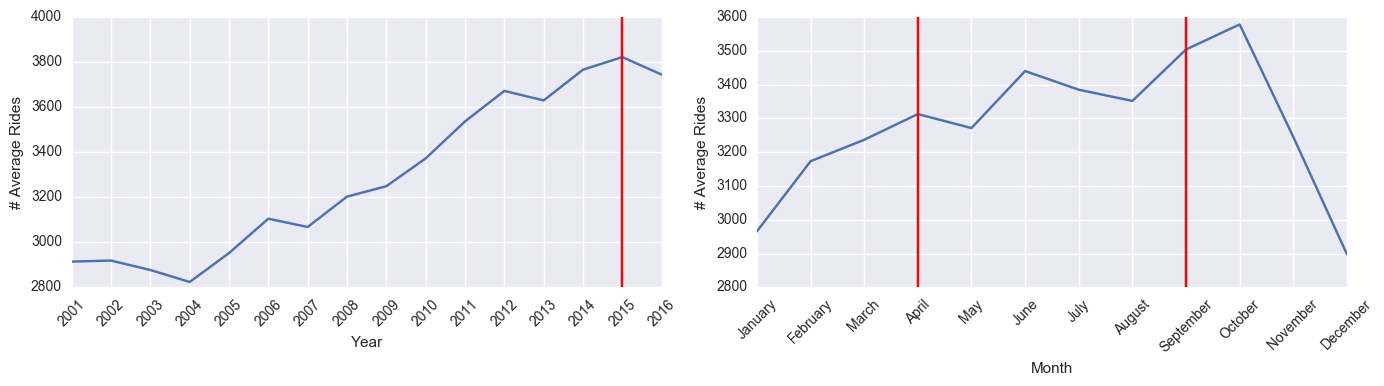

In [10]:
# what are the current trends, are people still riding the CTA
# Note that we didn't have all the data for 2016
rides_by_year  = df_cta_fe.groupby(df_cta_fe['date'].dt.year)['rides'].mean()
rides_by_month = df_cta_fe.groupby(df_cta_fe['date'].dt.month)['rides'].mean()
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(14,4))
# plot 1
rides_by_year.plot(ax=ax1, xticks=rides_by_year.index)
ax1.axvline(2015, c='r')
ax1.set_xlabel('Year')
ax1.set_ylabel('# Average Rides')
for item in ax1.get_xticklabels(): item.set_rotation(45)
# plot 2
rides_by_month.plot(ax=ax2, xticks=rides_by_month.index)
ax2.set_xticklabels(df_cta_fe['month'].unique())
for item in [4, 9]: ax2.axvline(item, c='r')
ax2.set_xlabel('Month')
ax2.set_ylabel('# Average Rides')
for item in ax2.get_xticklabels(): item.set_rotation(45)
plt.tight_layout()
plt.savefig('./../images/initial_trends.png')

### Criteria Exploration
- Let us explore some criteria of the business owner 
    - Weekends and Holidays
    - Weekends and Holidays during the time period of April-August
- We have a few initial key stations that meet our business owners criteria (holidays/weekends, April-August).  As well as there are some stations that are getting good traffic on weekdays as well during this sime criteria.

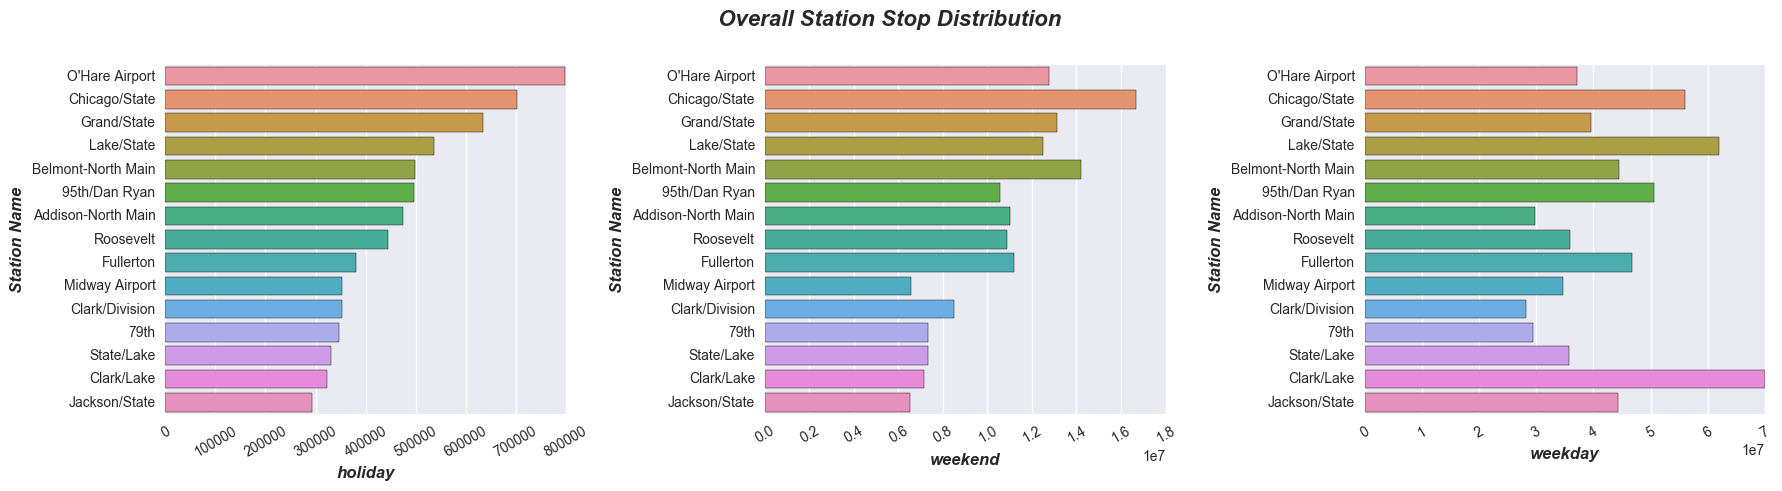

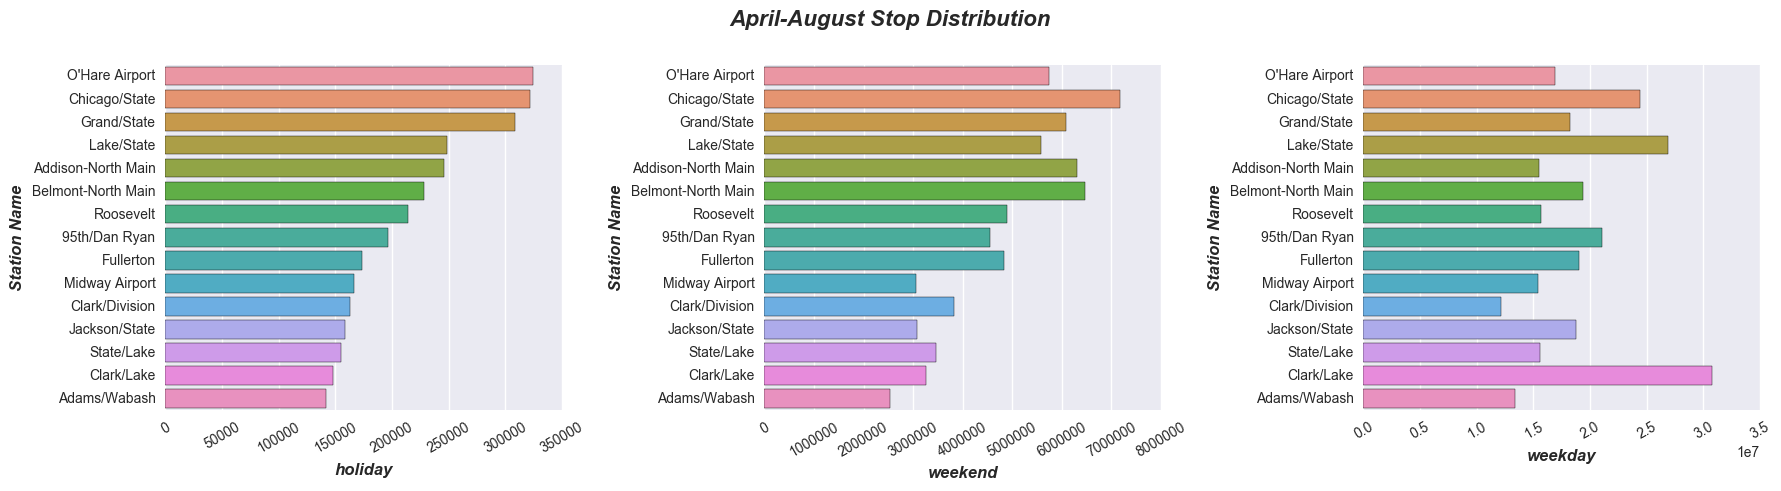

In [11]:
def calc_daytype_metrics(df_in):
    daytype_weekend = df_in[(df_in.dow == 'Saturday') | (df_in.dow == 'Sunday')]
    rides_weekend = daytype_weekend.groupby('stationname')['rides'].sum().sort_values(ascending=False)
    daytype_weekday = df_in[df_in.daytype_Weekday == 1]
    rides_weekday = daytype_weekday.groupby('stationname')['rides'].sum().sort_values(ascending=False)
    daytype_holiday = df_in[df_in.daytype_Holiday == 1]
    rides_holiday = daytype_holiday.groupby('stationname')['rides'].sum().sort_values(ascending=False)
    frame = rides_holiday.to_frame().join(rides_weekend.to_frame(), lsuffix='_holiday', rsuffix='_weekend')
    frame = frame.join(rides_weekday).rename(columns={'rides':'rides_weekday'})
    return frame

def explore_daytypes(df_in, title):
    fig, ax = plt.subplots(1, 3, figsize=(18,5))
    for axi, col in zip(ax.flatten(), df_in.columns):
        data = df_in[col]
        xlabel = col.split('_')[1]
        sns.barplot(data[:15], data[:15].index, orient='h', ax=axi)
        axi.set_ylabel('Station Name', fontweight='bold', fontsize=12, style='italic')
        axi.set_xlabel(xlabel, fontweight='bold', fontsize=12, style='italic')
        for item in axi.get_xticklabels(): item.set_rotation(30)
    plt.suptitle(title, fontsize=16, fontweight='bold', style='italic')
    plt.subplots_adjust(top=0.10, bottom=0.075)
    plt.tight_layout()
    #plt.savefig('./../images/' + title + '.png')

df_cta_daytype_metrics = calc_daytype_metrics(df_cta_fe)
# Total Station Distribution Across different types of days; {Holidays, Weekends, Weekdays}
explore_daytypes(df_cta_daytype_metrics, title = "Overall Station Stop Distribution")
# Station Distribution across time frame of April-August (Prime Period)
month_filter = ['April', 'May', 'June', 'July', 'August']
df_cta_prime = df_cta_fe[df_cta_fe['month'].isin(month_filter)]
df_cta_prime_metrics = calc_daytype_metrics(df_cta_prime)
explore_daytypes(df_cta_prime_metrics, title = "April-August Stop Distribution")

### Central Connecting Stations
- There are some stations that can be considered as **central hubs**: many different lines have stops connected at the station from different lines.  These should be looked at further to determine if the traffic aligns with the criteria from the business owner at possible locations.

In [12]:
# which stops are the most connected, and noted as central hubs
# alternatively we can look at the transition vertices (stations) as an edge list
# We would like to know the junction points, only given via the descriptive name (e.g. State/Lake)
# Define a Hub as
def extract_junctions(sta_descriptive):
    # summing over the lines themselves does not give us the number of true changeover points
    sta_name, junctions = sta_descriptive.split('(')
    junctions = junctions.rstrip(')').replace('&',',').split(',')
    n_junctions = len(junctions)
    #print "sta:{0}, junc:{1}, njunc:{2}".format( sta_name, junctions, n_junctions )
    return n_junctions

n_hub_threshold = 3
df_cta_info_fe = df_cta_info_cl.copy()
df_cta_info_fe.loc[:,'NUM_JUNCTIONS']  = df_cta_info_fe['STATION_DESCRIPTIVE_NAME'].apply(extract_junctions)
df_cta_info_fe.loc[:,'STATION_AS_HUB'] = df_cta_info_fe['NUM_JUNCTIONS'] >= n_hub_threshold
cols = ['STATION_NAME', 'DIRECTION_ID', 'MAP_ID', 'NUM_JUNCTIONS', 'STATION_AS_HUB']
df_cta_info_fe[cols].sort_values(by=['NUM_JUNCTIONS', 'STATION_NAME'], ascending=False).head()

,STATION_NAME,DIRECTION_ID,MAP_ID,NUM_JUNCTIONS,STATION_AS_HUB
68,Clark/Lake,E,40380,6,True
69,Clark/Lake,W,40380,6,True
70,Clark/Lake,S,40380,6,True
71,Clark/Lake,N,40380,6,True
243,State/Lake,E,40260,5,True


### Train Line Analysis
Based on using the prior criteria of the business owner (e.g. time of year)
- Do some lines not have enough daily records (Lines P and Y have a majority less than others)
- Which lines have fewer/more stops than others (fewer stops may not allow for maximizing patrons)
- How do the riderships compare
- Central Hubs, Number of of Junctions (Closer to a junction would benefit ridership)

In [13]:
# Determine lines that are most active based on number of stops and activity on a line 
# Also based on the previous criteria from the business customer
def calc_lineinfo(df_riders_in, df_info_in):
    df_lines_agg = pd.DataFrame()
    agg_cols = ['NUM_JUNCTIONS', 'STATION_AS_HUB']
    lines = ['ADA','RED', 'BLUE', 'G', 'BRN', 'P', 'Y', 'Pnk', 'Pexp', 'O']
    n_lines = df_info_in.groupby('MAP_ID')[lines].agg(lambda x: np.sum(x)).shape[0]   
    for line in lines:
        df_line = df_info_in[df_info_in[line] == True]
        df_junc = df_line.groupby('MAP_ID')[agg_cols].agg(lambda x: ( np.unique(x)[0]) )
        df_line = df_line.groupby('MAP_ID')[lines].agg(lambda x: np.sum(x, axis=0)).astype(np.bool)
        df_line = df_line.reset_index()
        df_line_m = df_riders_in.merge(df_line, left_on='station_id', right_on='MAP_ID')
        n_line_stops, n_line_records = (df_line.shape[0], df_line_m['date'].count())
        n_line_rides, n_avg_line_rides = (df_line_m['rides'].sum(), df_line_m['rides'].mean())
        n_junctions, n_hubs = (df_junc['NUM_JUNCTIONS'].sum(), df_junc['STATION_AS_HUB'].sum())
        line_dict = {'line':line, 'num_stops':n_line_stops, 'daily_records':n_line_records,
                     'total_rides': n_line_rides, 'avg_rides': n_avg_line_rides,
                     'num_junctions': n_junctions, 'num_hubs': n_hubs}
        df_lines_agg = df_lines_agg.append(line_dict, ignore_index=True)
    df_lines_agg = reorder_cols(df_lines_agg.set_index('line', drop=True).astype(int), '_rides')
    return n_lines, df_lines_agg

n_lines, df_line_agg = calc_lineinfo(df_cta_prime, df_cta_info_fe)
print 'Number of Total Lines: {}'.format(n_lines)
df_line_agg.sort_values(by='daily_records', ascending=False).drop('ADA',axis=0)

Number of Total Lines: 144


,daily_records,num_hubs,num_junctions,num_stops,avg_rides,total_rides
line,,,,,,
BLUE,79957,1,38,33,3644,291384705
RED,77462,3,38,32,5705,441981056
G,70157,6,57,31,2730,191545574
BRN,67780,11,71,28,4261,288836968
Pexp,62946,12,71,26,4288,269961003
Pnk,53244,9,59,23,3214,171135650
O,41157,10,52,17,5087,209366363
P,21799,1,11,9,1610,35111608
Y,4845,1,5,3,3719,18021279


In [14]:
# Pearson Correlation Patterns
df_line_agg.corr()

,daily_records,num_hubs,num_junctions,num_stops,avg_rides,total_rides
daily_records,1.000000,0.182934,0.867353,0.999520,0.080421,0.958156
num_hubs,0.182934,1.000000,0.640736,0.178196,0.325305,0.215374
num_junctions,0.867353,0.640736,1.000000,0.866401,0.165575,0.829834
num_stops,0.999520,0.178196,0.866401,1.000000,0.065166,0.951911
avg_rides,0.080421,0.325305,0.165575,0.065166,1.000000,0.337495
total_rides,0.958156,0.215374,0.829834,0.951911,0.337495,1.000000


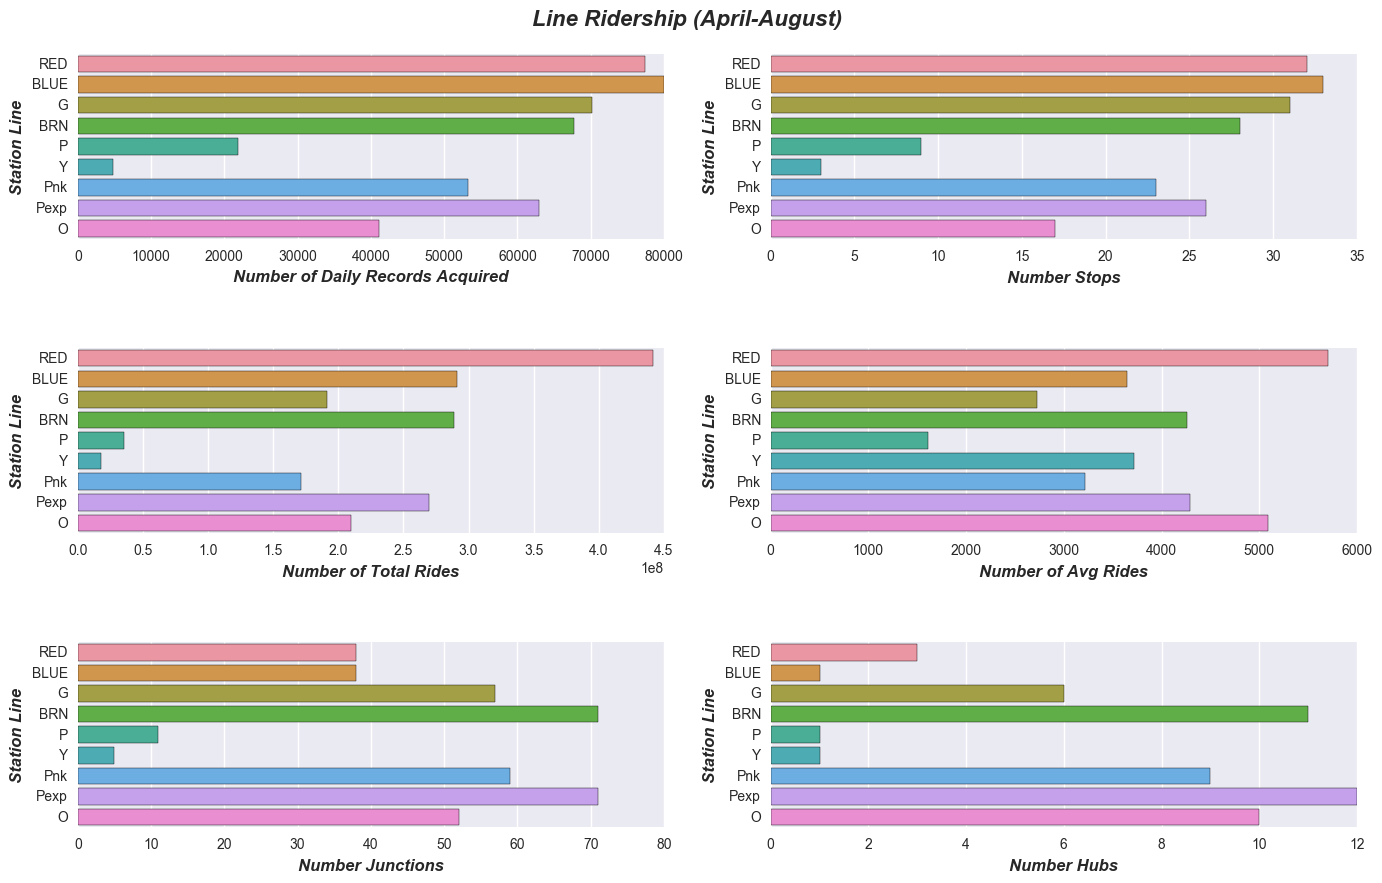

In [15]:
# Plot Information about ridership and lines
fig, ax = plt.subplots(3, 2, figsize=(14,9))
labels = ['Number of Daily Records Acquired', 'Number Stops', 
          'Number of Total Rides', 'Number of Avg Rides',
          'Number Junctions', 'Number Hubs']
cols = ['daily_records', 'num_stops','total_rides', 'avg_rides', 'num_junctions', 'num_hubs']
for axi, col, xlabel in zip(ax.flatten(), cols, labels):
    # keeping the same y-axis for consistency rather than sorting by value
    data = df_line_agg[col].drop('ADA',axis=0)
    sns.barplot(data, data.index, orient='h', ax=axi)
    axi.set_ylabel('Station Line', fontweight='bold', fontsize=12, style='italic')
    axi.set_xlabel(xlabel, fontweight='bold', fontsize=12, style='italic')
    for item in axi.get_xticklabels(): item.set_rotation(0)
title = 'Line Ridership (April-August) '
plt.suptitle(title, fontsize=16, fontweight='bold', style='italic')
plt.subplots_adjust(top=0.10, bottom=0.075)
plt.tight_layout()
plt.savefig('./../images/line_ridership_distribution.png')

### Timeline Irregularities
- Possible Periods during big drops or bursts in activity via deviations
- Volatility: trends over time, we would like a more stable estimate

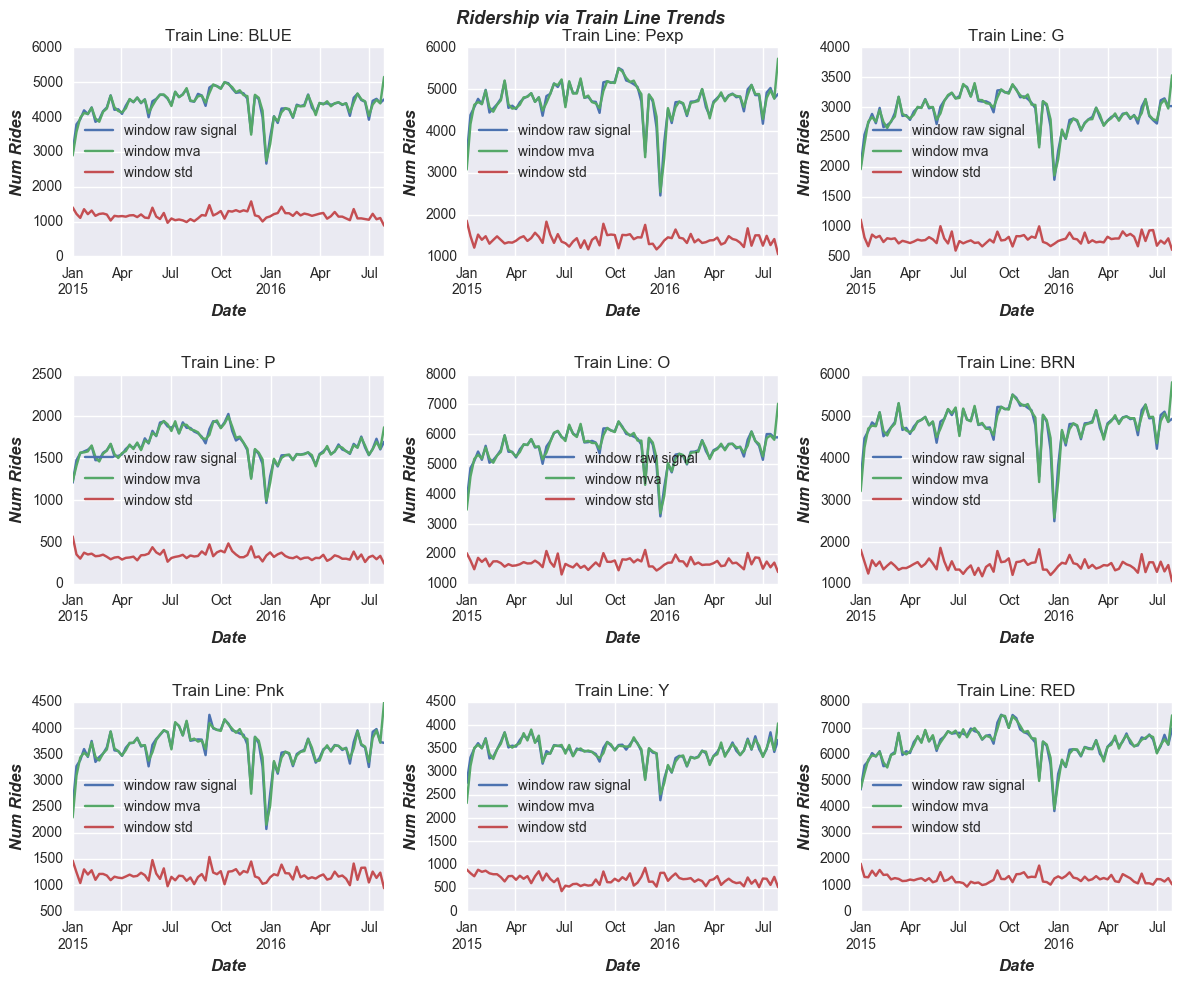

In [16]:
# calculate window metrics for trend analysis
def calc_rolling_metric(frame, window_size, rolling_metric=None):
    if rolling_metric == 'std':
        frame_metric = frame.rolling(window=window_size, min_periods=1).std()
    elif rolling_metric == 'mva':
        # unweighted mean of window_size
        frame_metric = frame.rolling(window=window_size, min_periods=1).mean()
    elif rolling_metric == 'ew_std':
        frame_metric = frame.ewm(span=window_size, min_periods=1).std()        
    elif rolling_metric == 'ew_mva':
        frame_metric = frame.ewm(span=window_size, min_periods=1).mean()
    else: 
        frame_metric = frame
    frame_metric = frame_metric.resample('7d').mean()
    return frame_metric


def plot_rolling_metric(df_in, title, label, axi):
    if not label: label = 'raw signal'
    df_in.plot(label=label, ax=axi)
    axi.set_xlabel("Date", fontweight='bold', fontsize=12, style='italic')
    axi.set_ylabel("Num Rides", fontweight='bold', fontsize=12, style='italic')
    axi.set_title("Train Line: " + title)
    axi.legend(loc='best')

# consolidate line and ridership information
def consolidate_ridership_lines(df_rides_in, df_info_in, lines):
    df_lines = df_cta_info_fe.groupby('MAP_ID')[lines].agg(lambda x: np.sum(x, axis=0)).astype(np.bool)
    df_lines = df_lines.reset_index()
    df_lines_m = df_rides_in.merge(df_lines, left_on='station_id', right_on='MAP_ID')
    return df_lines_m

# determine trends and volatility periods in train lines 
def train_line_trends(df_rides_in, df_info_in):
    line_metric_dict = {}
    # gather ridership information per a line
    lines = ['RED', 'BLUE', 'G', 'BRN', 'P', 'Y', 'Pnk', 'Pexp', 'O']
    df_rides_flt = df_rides_in[df_rides_in['date'].dt.year > 2014]
    df_lines = consolidate_ridership_lines(df_rides_flt, df_info_in, lines)
    df_lines_flt = df_lines[['date', 'rides'] + lines].set_index('date')
    line_dict = {line: df_lines_flt[df_lines_flt[line] == True]['rides'] for line in lines}
    # plot metrics
    fig, ax = plt.subplots(3, 3, figsize=(12,10))
    for axi, (label, frame) in zip(ax.flatten(), line_dict.iteritems()):
        for metric in [None, 'mva', 'std']:
            df_metric = calc_rolling_metric(frame, window_size=4, rolling_metric=metric)
            if metric == 'std': line_metric_dict[label] = df_metric
            if not metric: metric = 'raw signal'
            plot_rolling_metric(df_metric, label, 'window ' + metric, axi)
    
    plt.suptitle("Ridership via Train Line Trends", fontsize=13, fontweight='bold', style='italic')
    plt.subplots_adjust(top=0.05, bottom=0.025)
    plt.tight_layout()
    plt.savefig('./../images/ridership_line_trends.png')
    return line_metric_dict
        
line_dict = train_line_trends(df_cta_fe, df_cta_info_fe)

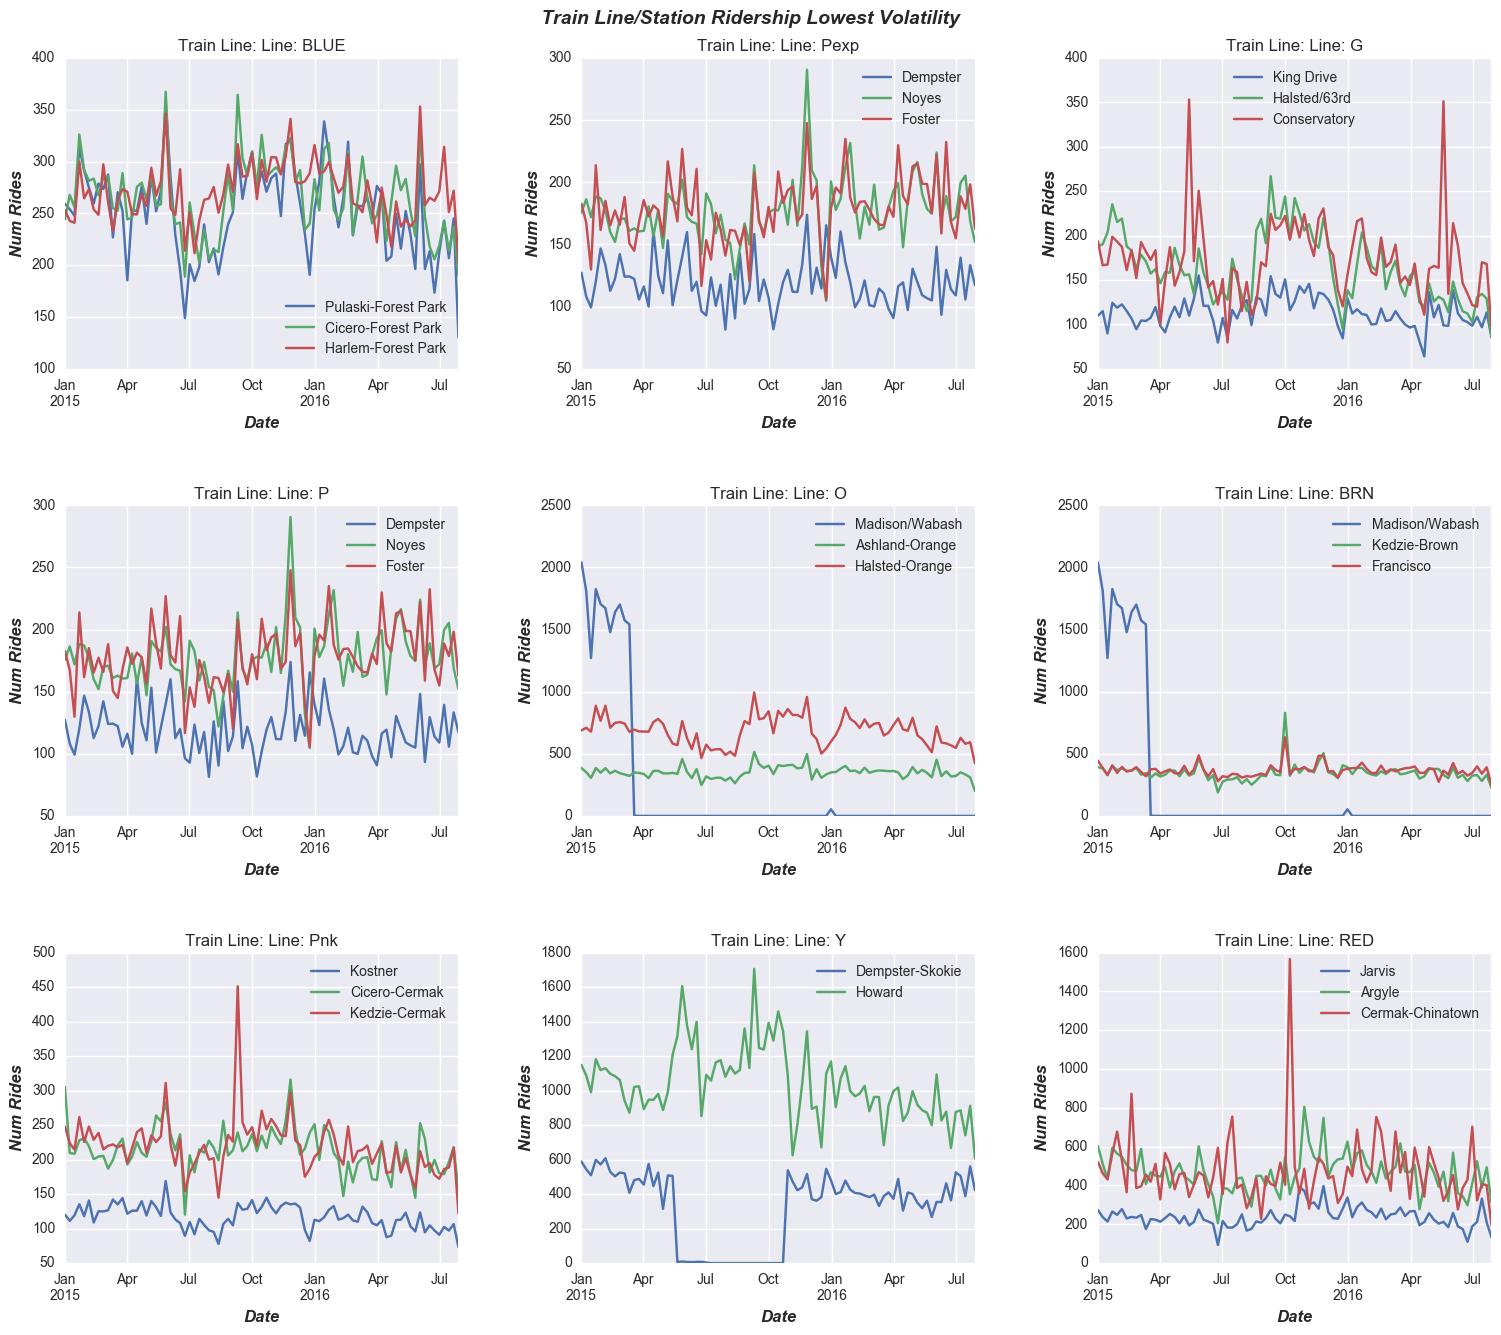

In [17]:
# Narrow down on particular Station Trends per a particular line
def line_station_volatility(df_rides_in, df_info_in):
    lines_dict = {}
    lines = ['RED', 'BLUE', 'G', 'BRN', 'P', 'Y', 'Pnk', 'Pexp', 'O']
    df_rides_flt = df_rides_in[df_rides_in['date'].dt.year > 2014]
    df_lines = consolidate_ridership_lines(df_rides_flt, df_info_in, lines)
    df_lines_flt = df_lines[['station_id','stationname'] + ['date', 'rides'] + lines]
    for line in lines:
        station_dict = {}
        df_line = df_lines_flt[df_lines_flt[line] == True]        
        stations = df_line.stationname.unique()
        for station in stations:
            df_station = df_line[df_line.stationname == station]
            df_station = df_station.set_index('date')['rides']
            station_metric = calc_rolling_metric(df_station, window_size=4, rolling_metric='std')
            station_dict[station] = (station_metric.mean(), station_metric)
        lines_dict[line] = station_dict
    return lines_dict

k_stations=3
fig, ax = plt.subplots(3, 3, figsize=(16,14))
lines_dict = line_station_volatility(df_cta_fe, df_cta_info_fe)
for axi, (line, station_dict) in zip(ax.flatten(), lines_dict.iteritems()): 
    lowest_volatile_stations = sorted(station_dict.items(), key=lambda x: x[1][0], reverse=False)
    for station, (volatility_index, frame_metric) in lowest_volatile_stations[:k_stations]:
        title = 'Line: {}'.format(line)
        plot_rolling_metric(frame_metric, title, station, axi)
        
plt.suptitle("Train Line/Station Ridership Lowest Volatility", fontsize=14, fontweight='bold', style='italic')
plt.tight_layout(pad=3.5)
plt.savefig('./../images/line_station_volatility.png')

Station, Average Volatility:	Grand/State, 1531.37460925
Station, Average Volatility:	Belmont-North Main, 1857.68785736
Station, Average Volatility:	Lake/State, 4424.97394809
Station, Average Volatility:	Addison-North Main, 2072.04894073
Station, Average Volatility:	Chicago/State, 2178.644586

Station Average Ridership:  stationname
Addison-North Main     8324.271626
Roosevelt             10402.126298
Grand/State           11849.228374
Belmont-North Main    11875.735294
Chicago/State         14303.908304
Lake/State            19092.574394
Name: rides, dtype: float64


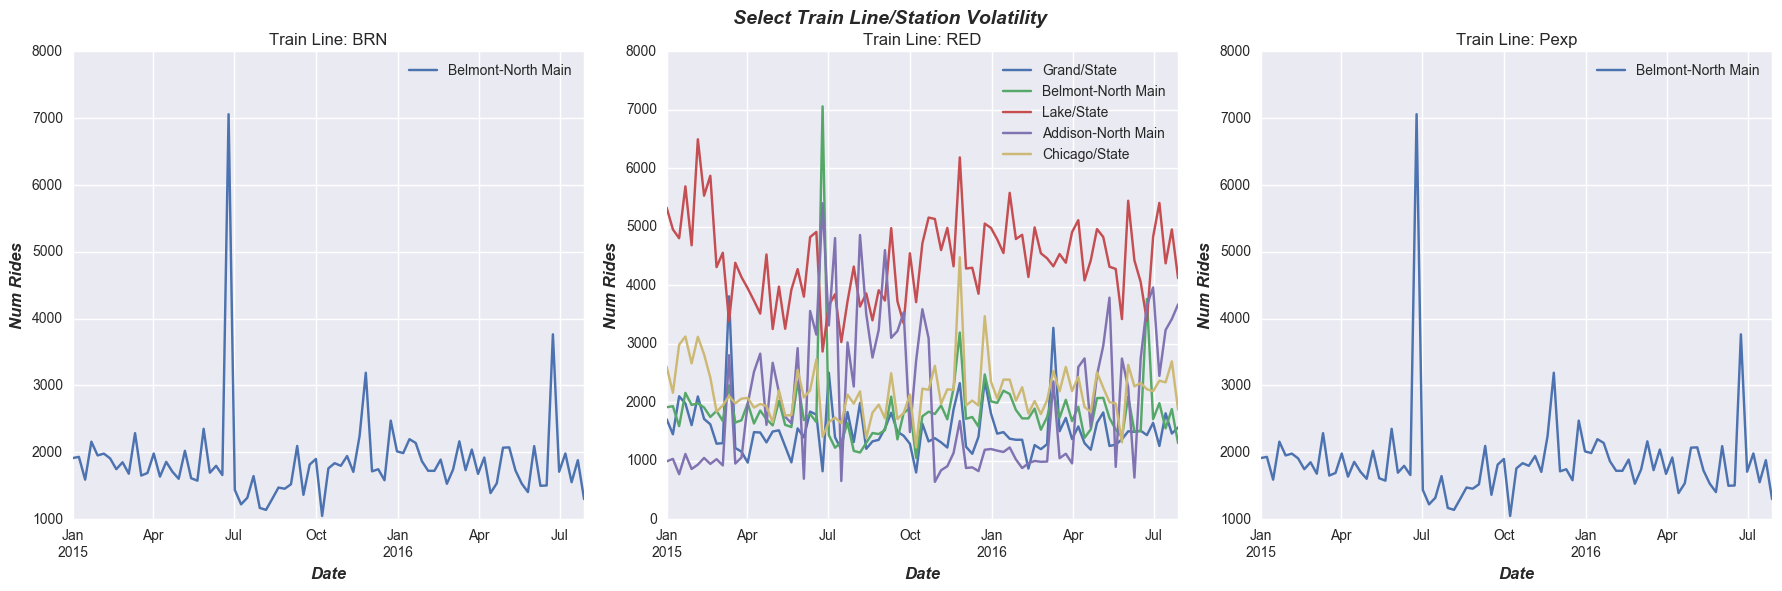

In [18]:
# Review Volatilty of Select Stations
data = [(41320, 'Belmont-North Main'), (41420, 'Addison-North Main'),
        (41450, 'Chicago/State'),(41660, 'Lake/State'),(40330, 'Grand/State'),
        (41400, 'Roosevelt')]
station_names = map(lambda x: x[1], data)
lines = ['RED','BRN','Pexp']
lines_dict_flt = {line: lines_dict[line] for line in lines}
fig, ax = plt.subplots(1, 3, figsize=(18,6))
for axi, (line,station_dict) in zip(ax.flatten(), lines_dict_flt.iteritems()):
    for station, (avg_volatility, ts), in station_dict.iteritems():
        if station in station_names and line in lines:
            plot_rolling_metric(ts, line, station, axi)

plt.suptitle("Select Train Line/Station Volatility", fontsize=14, fontweight='bold', style='italic')
plt.subplots_adjust(top=0.05, bottom=0.025)
plt.tight_layout()
plt.savefig('./../images/select_line_station_volatility.png')

for station_name, (avg_volatility,ts) in lines_dict_flt['RED'].iteritems(): 
    if station_name in station_names: 
        print "Station, Average Volatility:\t{0}, {1}".format(station_name, avg_volatility)

df_rides_flt = df_cta_fe[df_cta_fe['date'].dt.year > 2014]
df_rides_flt = df_rides_flt[df_rides_flt.stationname.isin(station_names)]
print '\nStation Average Ridership: ',df_rides_flt.groupby('stationname')['rides'].mean().sort_values()

### Aggregate information for better visualization
- Via Geographical Map using Lat/Long Coordinates
- Apply colormap based on thresholds

In [113]:
def extract_latlong(ds):
    ds['Lat'], ds['Long'] = ds['Location'].replace('(','').replace(')','').split(',')
    return ds

def aggregate_per_map(df_agg_in, df_rides_in, df_info_in):
    cols = ['station_id', 'stationname', 'rides_holiday', 'rides_weekend', 'rides_weekday']
    agg_data = df_agg_in.reset_index()
    agg_data = agg_data.merge(df_rides_in, on='stationname')[cols].drop_duplicates()#.reset_index()
    cols  = ['MAP_ID', 'STATION_NAME', 'Lat', 'Long', 'NUM_JUNCTIONS', 'STATION_AS_HUB']  
    data = agg_data.merge(df_info_in[cols], left_on='station_id', right_on='MAP_ID')
    data = data.drop_duplicates().reset_index().drop(['STATION_NAME','MAP_ID','index'],axis=1)
    return data

def rescale_data(frame, cols):
    rescale = lambda x,a,b: (b-a)* (((x - min_val)/(max_val-min_val)) + a)
    for col in cols:
        min_val, max_val = (frame[col].min(), frame[col].max())
        frame[col+ '_scaled'] = frame[col].map(lambda x: rescale(x,0.1,1.0))
    return frame 

def create_station_volatility(data_dict_in):
    volatility_dict = {}
    for line, station_dict in data_dict_in.iteritems(): 
        for station, (volatility_index, frame_metric) in station_dict.iteritems():
            data = volatility_dict.get(station, [])
            data.append(volatility_index)
            volatility_dict[station] = data
    for k,v in volatility_dict.items():
        volatility_dict[k] = np.mean(v)
    df_volatility = pd.Series(volatility_dict).reset_index()
    df_volatility.columns = ['stationname', 'volatility']
    df_volatility = df_volatility.merge(df_cta_fe, on='stationname')\
    [['station_id', 'stationname', 'volatility']].drop_duplicates()
    df_volatility = df_volatility.merge(df_cta_info_fe, left_on='station_id', right_on='MAP_ID')\
    [['station_id', 'stationname', 'volatility', 'Lat', 'Long']].drop_duplicates()
    df_volatility = rescale_data(df_volatility.copy(), ['volatility'])
    return df_volatility

# colormap via thresholds: Streelight pattern: RED=LOW,GREEN=HIGH Recommendation
palette = sns.color_palette("RdYlGn", 10).as_hex()
find_colors = dict( zip(np.linspace(0.1,1,10).astype(float), palette ) )
find_colors_rev = dict( zip(sorted(np.linspace(0.1,1,10).astype(float), reverse=True), palette ) )
df_cta_info_fe = df_cta_info_fe.apply(extract_latlong, axis=1)
# volatility index
df_volatility_index = create_station_volatility(lines_dict)
# aggregation values: per df_cta_{daytype,prime}_metrics
df_daytype_agg = aggregate_per_map(df_cta_daytype_metrics, df_cta_fe, df_cta_info_fe)
df_daytype_agg = rescale_data(df_daytype_agg, ['rides_holiday','rides_weekend','rides_weekday'])
df_prime_agg   = aggregate_per_map(df_cta_prime_metrics, df_cta_fe, df_cta_info_fe)
df_prime_agg   = rescale_data(df_prime_agg.copy(), ['rides_holiday','rides_weekend','rides_weekday'])
display( df_prime_agg.head() )

,station_id,stationname,rides_holiday,rides_weekend,rides_weekday,Lat,Long,NUM_JUNCTIONS,STATION_AS_HUB,rides_holiday_scaled,rides_weekend_scaled,rides_weekday_scaled
0,40890,O'Hare Airport,324806,5743413,16878760,41.97766526,-87.90422307,1,False,0.990000,0.807245,0.575204
1,41450,Chicago/State,321892,7177338,24383685,41.896671,-87.628176,1,False,0.981781,0.990000,0.799836
2,40330,Grand/State,308146,6082793,18187482,41.891665,-87.628021,1,False,0.943008,0.850499,0.614376
3,41660,Lake/State,249005,5580284,26868165,41.884809,-87.627813,1,False,0.776192,0.786454,0.874200
4,41420,Addison-North Main,245701,6298474,15454409,41.947428,-87.653626,1,False,0.766873,0.877988,0.532572


In [114]:
# Verify the Lines that go through them
def consolidate_station_lines(df_info_in):
    lines = ['RED', 'BLUE', 'G', 'BRN', 'P', 'Y', 'Pnk', 'Pexp', 'O']
    opt   = ['STATION_AS_HUB']
    df_lines = df_info_in.groupby(['MAP_ID', 'STATION_NAME'])[lines+opt].agg(lambda x: np.sum(x, axis=0)).astype(np.bool)
    df_lines = df_lines.reset_index()
    return df_lines

df_cta_lines   = consolidate_station_lines(df_cta_info_fe)
display( df_cta_lines.head() )
# Verify Lines on Select Search Stations
data = [(41320, 'Belmont-North Main'), (41420, 'Addison-North Main'),
        (41450, 'Chicago/State'),(41660, 'Lake/State'),(40330, 'Grand/State'),
        (41400, 'Roosevelt')]
df_cta_lines[df_cta_lines['MAP_ID'].isin(map(lambda x: x[0],data))]    

,MAP_ID,STATION_NAME,RED,BLUE,G,BRN,P,Y,Pnk,Pexp,O,STATION_AS_HUB
0,40010,Austin,False,True,False,False,False,False,False,False,False,False
1,40020,Harlem/Lake,False,False,True,False,False,False,False,False,False,False
2,40030,Pulaski,False,False,True,False,False,False,False,False,False,False
3,40040,Quincy/Wells,False,False,False,True,False,False,True,True,True,True
4,40050,Davis,False,False,False,False,True,False,False,True,False,False


,MAP_ID,STATION_NAME,RED,BLUE,G,BRN,P,Y,Pnk,Pexp,O,STATION_AS_HUB
31,40330,Grand,True,False,False,False,False,False,False,False,False,False
123,41320,Belmont,True,False,False,True,False,False,False,True,False,True
129,41400,Roosevelt,False,False,True,False,False,False,False,False,True,True
131,41420,Addison,True,False,False,False,False,False,False,False,False,False
134,41450,Chicago,True,False,False,False,False,False,False,False,False,False
140,41660,Lake,True,False,False,False,False,False,False,False,False,False


In [123]:
# folium baed implementation
cols = ['rides_holiday','rides_weekend','rides_weekday']
map_folium = folium.Map(location=[41.884809, -87.627813], zoom_start=10)#, width=625, height = 400)
map_folium.add_child(folium.LatLngPopup())
def plot_aggregations(df_in, col):
    data = df_in[col]
    thresh = np.array( sorted( find_colors.keys()) )
    color = find_colors[ thresh[ np.argmax(data <=thresh) - 1] if data!= 1.0 else 1.0 ]
    folium.RegularPolygonMarker(
         location=[df_in['Lat'], df_in['Long']], popup=df_in['stationname'], 
         fill_color=color, number_of_sides=3, radius=10
         ).add_to(map_folium)

# modify the col to iterate over the map (April-August: Holidays)
_ = df_prime_agg.apply(lambda x: plot_aggregations(x, cols[0]+'_scaled'), axis=1) 
map_folium

In [124]:
credentials = yaml.load(open('./../config/credentials.yml'))
mapbox_access_token = credentials['MAPBOX_ACCESS_TOKEN']

def color_aggregations(df_in, col, rev_state=False):
    data = df_in[col]
    thresh = np.array( sorted( find_colors.keys()) )
    if not rev_state:
        color = find_colors[ thresh[ np.argmax(data <=thresh) - 1] if data!= 1.0 else 1.0 ]
    else:
        color = find_colors_rev[ thresh[ np.argmax(data <=thresh) - 1] if data!= 1.0 else 1.0 ]        
    return color

def plot_aggregations(df_in, col, title, rev_state=False):
    colors_data = df_in.apply(lambda x: color_aggregations(x, col +'_scaled', rev_state), axis=1)
    data = go.Data([
        go.Scattermapbox(
            lat=df_in['Lat'].values,
            lon=df_in['Long'].values,
            mode='markers',
            marker=go.Marker(
                size=9,
                color=colors_data
            ),
            text=df_in['stationname'].values,
        )
    ])
    layout = go.Layout(
        title = "April-August " + title + " Rideship",
        autosize=False,
        width=625,
        height=450,
        hovermode='closest',
        mapbox=dict(
            accesstoken=mapbox_access_token,
            style='streets',
            bearing=70,
            center=dict(
                lat=41.9,
                lon=-87.666
            ),
            pitch=0,
            zoom=10
        ),
    )
    fig_mapbox = dict(data=data, layout=layout)
    fname='Chicago {0} Aggregations'.format(title)
    return fig_mapbox, fname

In [131]:
#cols  = ['rides_holiday','rides_weekend','rides_weekday']
#title_name = cols[0].split('_')[1]
#title_name = title_name[0].upper() + title_name[1:]
#fig_plotly, fname = plot_aggregations(df_prime_agg, cols[0], title_name, rev_state=False)
#py.iplot(fig_plotly, filename=fname, validate=False)

fig_plotly, fname = plot_aggregations(df_volatility_index, 'volatility', 'Low Volatility Index', rev_state=True)
py.iplot(fig_plotly, filename=fname, validate=False)

### Reference the following Plotly Links: 
- Weekday Ridership: http://plot.ly/~ari.kamlani/4/april-august-weekday-rideship/
- Weekend Ridership: http://plot.ly/~ari.kamlani/2/april-august-weekend-rideship/
- Holiday Ridership: http://plot.ly/~ari.kamlani/0/april-august-holiday-rideship/
- Low Index Volatility Ridership: https://plot.ly/~ari.kamlani/8/april-august-low-volatility-index-rideship/

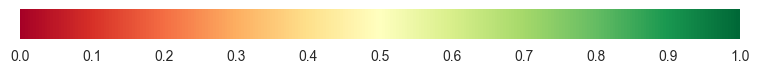

In [130]:
import matplotlib as mpl
fig = plt.figure(figsize=(8, 2))
ax1 = fig.add_axes([0.05, 0.80, 0.9, 0.15])
norm = mpl.colors.Normalize(vmin=0, vmax=1)
cb1  = mpl.colorbar.ColorbarBase(ax1, cmap = 'RdYlGn', norm=norm,orientation='horizontal')